# Proyecto Final: Radio Machine Learning Learning 2016.

**Autores:**  
* Jackeline Morales Hernandez

* Jose David Ortiz Miranda

**Tratamiento de Señales III**

**Facultad de Ingeniería**

**Universidad de Antioquia**

In [ ]:
!gdown '1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K'

Downloading...
From: https://drive.google.com/uc?id=1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K
To: /content/RML2016.10a_dict.pkl
100% 641M/641M [00:07<00:00, 82.7MB/s]


In [ ]:
import os,random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, sys
%matplotlib inline
from tensorflow import keras
from keras.utils import to_categorical
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *
from tensorflow.keras.layers import Conv2D
from sklearn.preprocessing import LabelBinarizer
#from tensorflow.keras.optimizers import adam
from sklearn.metrics import classification_report

In [ ]:
# Load the dataset ...
#  You will need to seperately download (radioml.com) or generate this file
with open("RML2016.10a_dict.pkl", 'rb') as f:
    Xd = pickle.load(f, encoding="latin1")

### ***Acceder con los keys a los dato se Xd que esta en formato Pickle***

In [ ]:
# Calculate modulations and signal-to-noise ratios contained in dataset
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

In [ ]:
# print('These are the modulation schemes in the dataset: {}'.format(mods))
# print('These are the signal to noise ratios in the dataset: {}'.format(snrs))

## ***Función para reconstruccion de la señal, aplicando:***

$$\text{Modulated Carrier RF} = I \cos(2\pi ft) + Q \sin(2 \pi ft)$$

In [ ]:
'''
Compute the original RF signal from the I & Q components.
'''
def reconstructSignal(s):
    I = s[0,:]   # I component
    Q = s[1,:]   # Q component
    n = len(I)   # number of samples
    f = 1e6     # Carrier frequency
    return I*np.cos(2*np.pi*f*np.arange(n)) + Q*np.sin(2*np.pi*f*np.arange(n))

Text(0.5, 1.0, 'PAM4 @ 6 dB')

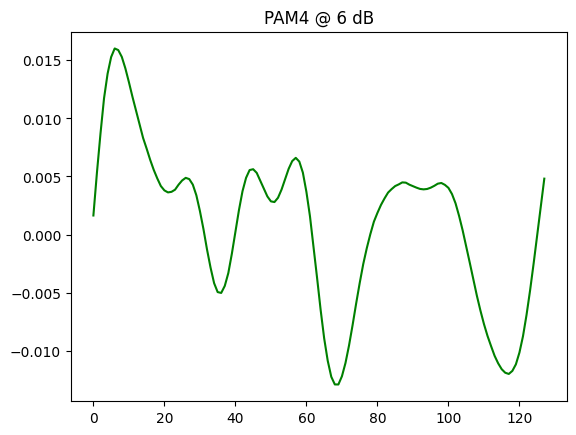

In [ ]:
plt.plot(reconstructSignal(Xd['PAM4', 18][99,:,:]), color='g');
plt.title('PAM4 @ 6 dB')

### ***Se recorren todos los datos con todas la modulaciones y sus respectivas relaciones SNR***

In [ ]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

### ***Se añade Ruido Blanco Gaussiano***

In [ ]:
numNoiseSamples = 20000 # Add 20,000 samples of just Gaussian noise
for i in range(numNoiseSamples):
    lbl.append(['Noise', snrs[i%len(snrs)]])

mods.append('Noise')
X_noise = np.random.normal(0, 0.01, [numNoiseSamples, 2, 128])
X = np.concatenate((X, X_noise))  # Add noise to the end of the data

***Se distingue cada modulación como con un código binario***

In [ ]:
lbl = np.array(lbl) # Convert from list to numpy array (for speed)

# This will encode the labels into a binary array.
# This is referred to as One-Hot.
# Each element of the array is either 1 or 0.
# The position of the element refers to which type of modulation.
# So if there are 11 modulation types, then the
# array is length 11.
# e.g.  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] codes '8PSK'
#       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] codes 'AM-DSB'
#       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] codes 'WBFM'
# We'll use this to compare the output of the neural network
# and help train the model to give the lowest error (in this case
# the cost will be the cross-entropy).
y_encoded = LabelBinarizer().fit_transform(lbl[:,0])

# print(y_encoded.shape)


### ***Dividimos entre datos de entrenamiento y test***

In [ ]:
# Partition the data
#  into training and test sets of the form we can train/test on
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.7)

# Now get a list of random indicies to sample for the training set
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# Testing set is whatever indicies are left over
test_idx = list(set(range(0,n_examples))-set(train_idx))

# Now split up the data by the random indicies
X_train = X[train_idx]
X_test =  X[test_idx]
Y_train = y_encoded[train_idx]
Y_test = y_encoded[test_idx]

#### ***Para ver los datos anteriormente sacados***

In [ ]:
# print('Training set is {}'.format(np.shape(X_train)))
# print('Test set is {}'.format(np.shape(X_test)))

In [ ]:
# in_shp = list(X_train.shape[1:])   # This is the input shape of 2 channels x 128 time samples
# print(X_train.shape, in_shp)
# classes = mods
#  print(classes)

# ***Tarea: Codificar al menos 2 arquitecturas neuronales para evaluar el reconocimiento de la modulación***

In [ ]:
from keras import backend
img_rows, img_cols = 2, 128
'''
if backend.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
'''
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (168000, 2, 128, 1)
X_test: (72000, 2, 128, 1)


### ***Se construye la red neuronal***

In [ ]:
# Build CNN Neural Net model using tensorflow  --
#  - Reshape [N,2,128] to [N,2,128,1] on input
#  - Pass through 3 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization


dr = 0.6 # dropout rate (%) = percentage of neurons to randomly lose each iteration
model = models.Sequential()  # Neural network is a set of sequential layers
#model.add(Convolution2D(...))
# number of convolutional filters to use
nb_classes = 12

# size of pooling area for max pooling
pool_size = (2, 2)


model.add(Conv2D(32, (2, 8),padding='valid',input_shape=input_shape,activation='relu',name='conv1'))
model.add(Conv2D(64, (1,3),activation='relu',padding='valid',name='conv2'))
model.add(Conv2D(128, (1,3),activation='relu',padding='valid',name='conv3'))
#model.add(MaxPooling2D(pool_size=pool_size,padding='same'))
model.add(Flatten(name='Flatten'))
model.add(Dense(units=256, activation='relu',name='Dense1'))
model.add(Dropout(dr,name='Drop1'))
model.add(Dense(units=nb_classes, activation='softmax',name='Dense2'))


print(model.summary())
# model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 1, 121, 32)        544       
                                                                 
 conv2 (Conv2D)              (None, 1, 119, 64)        6208      
                                                                 
 conv3 (Conv2D)              (None, 1, 117, 128)       24704     
                                                                 
 Flatten (Flatten)           (None, 14976)             0         
                                                                 
 Dense1 (Dense)              (None, 256)               3834112   
                                                                 
 Drop1 (Dropout)             (None, 256)               0         
                                                                 
 Dense2 (Dense)              (None, 12)                3

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

## ***Entrenando el modelo***

In [ ]:
# Set up some params
nb_epoch = 130 # number of epochs to train on
batch_size = 1024  # training batch size
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = './'
modelWeightsFile = filepath + 'PESOS_TSIII.wts.h5'  # Save the model weights to this file

history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(modelWeightsFile, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(modelWeightsFile)

Epoch 1/130

Epoch 1: val_loss improved from inf to 1.79087, saving model to ./PESOS_TSIII.wts.h5
165/165 - 11s - loss: 2.1140 - accuracy: 0.2303 - val_loss: 1.7909 - val_accuracy: 0.3388 - 11s/epoch - 67ms/step
Epoch 2/130


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.79087 to 1.67841, saving model to ./PESOS_TSIII.wts.h5
165/165 - 4s - loss: 1.7840 - accuracy: 0.3413 - val_loss: 1.6784 - val_accuracy: 0.3641 - 4s/epoch - 25ms/step
Epoch 3/130

Epoch 3: val_loss improved from 1.67841 to 1.56131, saving model to ./PESOS_TSIII.wts.h5
165/165 - 4s - loss: 1.7392 - accuracy: 0.3585 - val_loss: 1.5613 - val_accuracy: 0.4224 - 4s/epoch - 24ms/step
Epoch 4/130

Epoch 4: val_loss improved from 1.56131 to 1.50974, saving model to ./PESOS_TSIII.wts.h5
165/165 - 4s - loss: 1.6077 - accuracy: 0.4030 - val_loss: 1.5097 - val_accuracy: 0.4350 - 4s/epoch - 25ms/step
Epoch 5/130

Epoch 5: val_loss improved from 1.50974 to 1.48471, saving model to ./PESOS_TSIII.wts.h5
165/165 - 4s - loss: 1.5572 - accuracy: 0.4187 - val_loss: 1.4847 - val_accuracy: 0.4428 - 4s/epoch - 25ms/step
Epoch 6/130

Epoch 6: val_loss improved from 1.48471 to 1.40077, saving model to ./PESOS_TSIII.wts.h5
165/165 - 4s - loss: 1.5119 - accuracy: 0.4332 - val_l

## ***Evaluación del modelo***

In [ ]:
  # Supongamos que y_predict es tu array de predicciones y Y_test es tu conjunto de etiquetas reales
y_predict = model.predict(X_test,verbose=0)
y_pred=np.argmax(y_predict, axis=1)
y_test=np.argmax(Y_test, axis=1)
report = classification_report(y_test,y_pred,target_names=mods)

print(report)

              precision    recall  f1-score   support

        8PSK       0.71      0.47      0.56      5957
      AM-DSB       0.53      0.67      0.59      5852
      AM-SSB       0.27      0.89      0.41      5932
        BPSK       0.81      0.59      0.69      6051
       CPFSK       0.69      0.63      0.66      5963
        GFSK       0.78      0.63      0.70      6022
        PAM4       1.00      1.00      1.00      6125
       QAM16       0.88      0.67      0.76      5991
       QAM64       0.37      0.06      0.10      5906
        QPSK       0.52      0.70      0.59      6029
        WBFM       0.70      0.51      0.59      6072
       Noise       0.73      0.22      0.34      6100

    accuracy                           0.59     72000
   macro avg       0.67      0.59      0.58     72000
weighted avg       0.67      0.59      0.58     72000



## **Análisis**
- **CASO I:  N°filtros(conv1,conv2,conv3)=16,32,64 Padding='same' Neuronas=128**

  El entrenamiento del modelo se realizó con un valor de 130 épocas y un batch de 1024, dando como resultado un valor de 1.15171 en la pérdida de validación. Este entrenamiento se detuvo en la época 84, esto debido a que después de varias épocas no se encontró un mejor valor de pérdida por lo que se detiene para evitar el sobreentrenamiento.
   
  Al observar la tabla de clasificación se aprecian valores congruentes para algunas modulaciones, es decir sus 3 métricas(precision,recall, f1-score) tienen valores muy cercanos, que es lo ideal porque si la precisión es muy alta pero la sensibilidad y la especificidad son bajas, indica que hay mucha varianza en términos de su predicción lo que no es conveniente. De acuerdo con lo anterior se destacan las modulaciones 8PSK, AM-DSB, BPSK, GFSK,QPSK.

  Cabe destacar que la modulación PAM4 tuvo un valor de 100% en todas las métricas, esto se puede deber a que esta clase tenga una conjunto de entrenamiento bien equilibrado y representativo, lo que facilita que el modelo aprenda a distinguir esta clase de manera efectiva.


- **CASO II:  igual al CASO I solo se cambió el padding de 'same' a 'valid'**
  Con los mismos valores de entrenamiento, se detuvo en la epoca 94 con un valor de 1.10044 para la perdida de validación. Se aprecia que la tabla de clasificacion tuvo algunos cambios respecto al CASO I, como por ejemplo que ya algunas modulaciones no tienen un comportamiento esperado, solamente 4 modulaciones(AM-DSB, CPFSK, GFSK Y QPSK) tienen sus 3 metricas con valores parecidos.


- **Conclusiones CASO I Y CASO II**

  El uso del modo 'same' mostró un número menor de épocas, para evitar el sobreentrenamiento en el modelo, esto porque se detuvo en la época 84 mientras que usando 'valid' se detuvo en la época 94. Esto se puede deber a que el modo 'valid', que no implementa relleno, toma más tiempo en lograr ajustarse de una manera óptima a los datos.

  Respecto al valor de pérdida de validación se observó que en el CASO II fue menor, esto confirma lo presentado anteriormente, puesto que se tienen más épocas que llevan a mejorar el aprendizaje del modelo.


- **CASO III: N°filtros(conv1,conv2,conv3)=32,64,128 Padding='valid' Neuronas=128**

  En este caso se aumentaron los valores de los filtros pasando de 16,32,64 a 32,62,128. El modelo para este caso se detuvo en la época 117 con un valor de pérdida de validación de 1.11542. Las modulaciones que mejor desempeño tuvieron respecto a sus métricas fueron 8PSK, AM-DSB, CPFSK, GFSK QAM64 Y BPSK; siendo la mejor QAM64 ya que tuvo valores muy cercanos, casi iguales.


- **CASO IV: N°filtros(conv1,conv2,conv3)=32,64,128 Padding='valid' Neuronas=256**

  Para este escenario se quiso aumentar el valor de la capa densa pasando de 128 a 256. En estas condiciones la época se detuvo en el valor de 73, mostrando el resultado de pérdida de validación de 1.10245. En este escenario las modulaciones que mostraron mejor desempeño fueron 8PSK, AM-DSB, CPFSK, GFSK Y QPSK.


- **Conclusiones CASO III Y CASO IV**

  Entre estos casos la diferencia principal es el número de neuronas de la capa densa, al aumentar las neuronas el modelo puede aprender y procesar patrones más complejos que puedan haber dentro de los datos, este hecho se ve reflejado en el número de épocas y en el resultado del valor de pérdida de validación, es decir, con menos epocas el CASO IV logró un menor valor de pérdida de validación en comparación con el CASO III que uso más épocas y tuvo un valor de perdida un poco mayor.



## ***Curvas de pérdida***

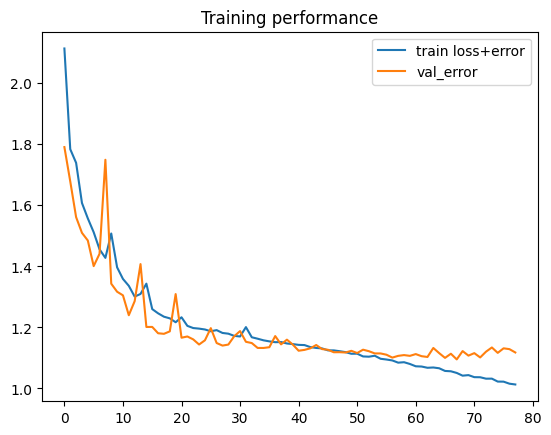

In [ ]:
# Show loss curves
plt.figure();
plt.title('Training performance');
plt.plot(history.epoch, history.history['loss'], label='train loss+error');
plt.plot(history.epoch, history.history['val_loss'], label='val_error');
plt.legend();

## **Análisis**

Se observa que la pérdida disminuye a lo largo de las épocas, como es esperado, y se aprecia que la línea de validación intenta acercarse a la de entrenamiento, lo que puede indicar que  el modelo está aprendiendo tanto del conjunto de entrenamiento como del conjunto de validación.
Los picos que pueden aparecer en la línea de validación se les puede atribuir a la presencia de datos inusuales  o extremos en el conjunto de validación para los cuales los modelos no son capaces de ajustarse.



## ***Matriz de confusión***

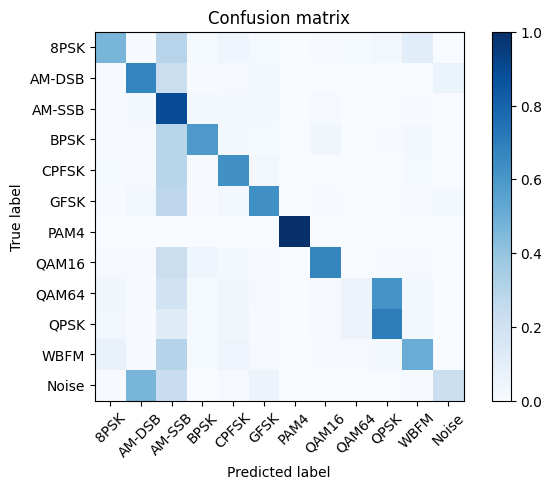

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
in_shp = list(X_train.shape[1:])   # This is the input shape of 2 channels x 128 time samples
classes = mods
test_Y_hat = model.predict(X_test, batch_size=batch_size,verbose=0)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)


## **Análisis de los cuatro casos**

Lo más notable en la matriz de confusión es su diagonal principal que representa los verdaderos positivos en las predicciones, es decir, las modulaciones que fueron clasificadas correctamente.
Adicionalmente la modulación que presentó mayor número de falsos positivos fue la modulación AM-SSB, debido a que en toda su columna muestra porcentajes de predicciones que no pertenecen a esta modulación, sin embargo, esta modulación presenta un porcentaje alto para su predicción verdadera positiva.
Haciendo un zoom a la matriz se puede observar que el modelo no distingue bien entre las modulaciones QAM64 Y QPSK, debido a que tal vez en estos conjuntos de datos se muestra patrones que para el modelo son muy similares lo que hace que su predicción presente más errores para estas dos modulaciones.


Overall Accuracy for SNR -20: 0.1645711092483934
Overall Accuracy for SNR -18: 0.17474383827194684
Overall Accuracy for SNR -16: 0.17299808690899152
Overall Accuracy for SNR -14: 0.18846578366445915
Overall Accuracy for SNR -12: 0.2294633077765608
Overall Accuracy for SNR -10: 0.3046663049376017
Overall Accuracy for SNR -8: 0.4040147017246254
Overall Accuracy for SNR -6: 0.5362440526168486
Overall Accuracy for SNR -4: 0.6276862963996651
Overall Accuracy for SNR -2: 0.6955322669608384
Overall Accuracy for SNR 0: 0.7584568073804865
Overall Accuracy for SNR 2: 0.8075736325385694
Overall Accuracy for SNR 4: 0.8322652549456673
Overall Accuracy for SNR 6: 0.8373826615129762
Overall Accuracy for SNR 8: 0.8412077159630975
Overall Accuracy for SNR 10: 0.8440443213296399
Overall Accuracy for SNR 12: 0.8298766816143498
Overall Accuracy for SNR 14: 0.8433192686357244
Overall Accuracy for SNR 16: 0.8280430582390285
Overall Accuracy for SNR 18: 0.8470982142857143


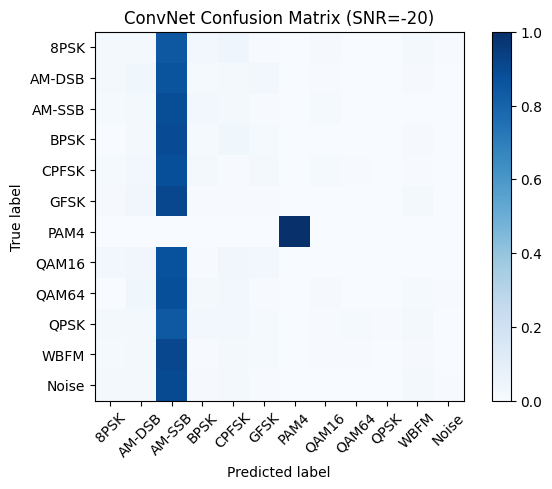

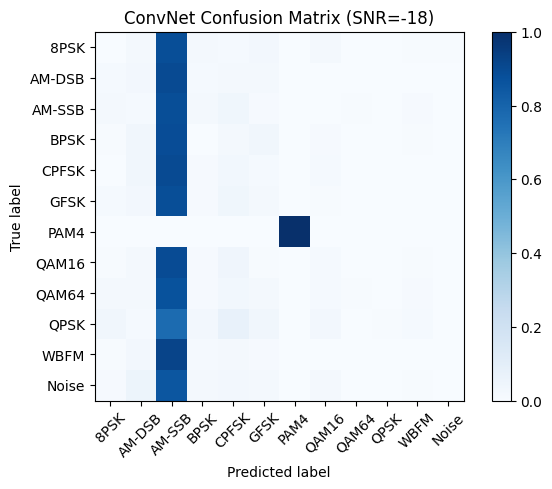

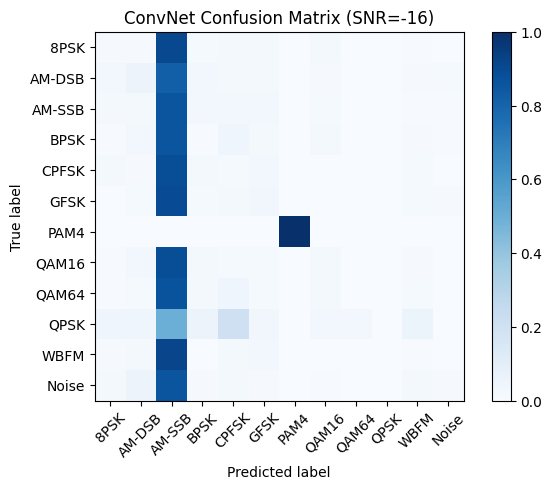

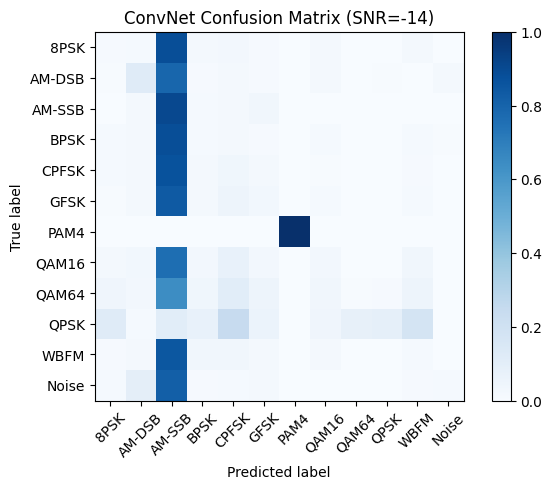

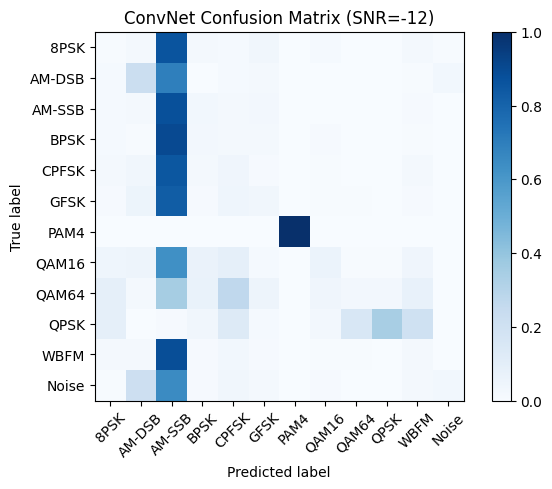

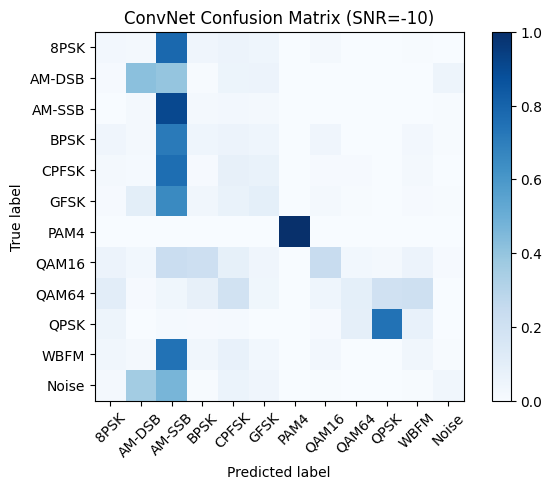

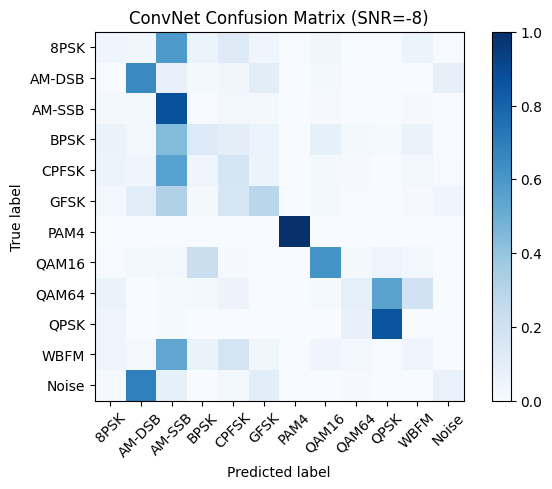

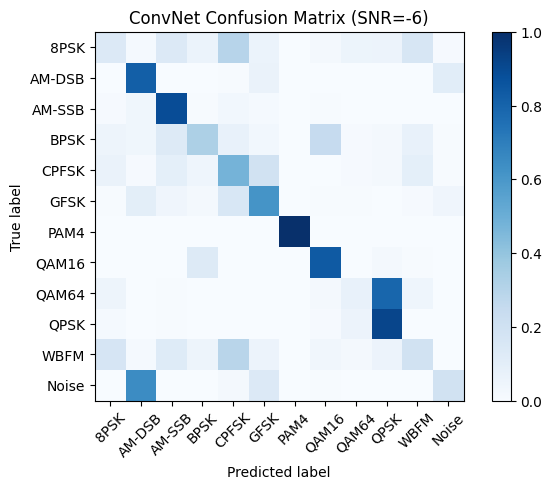

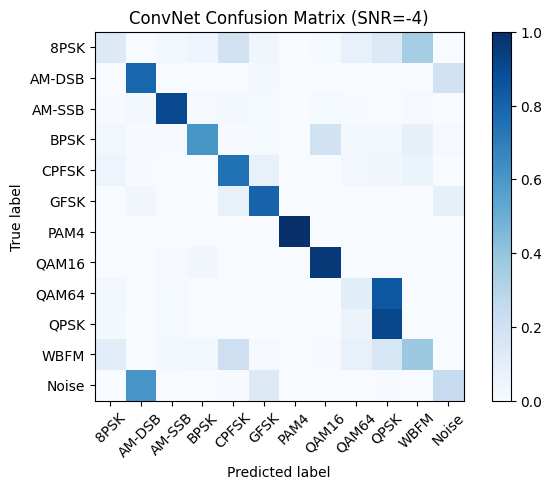

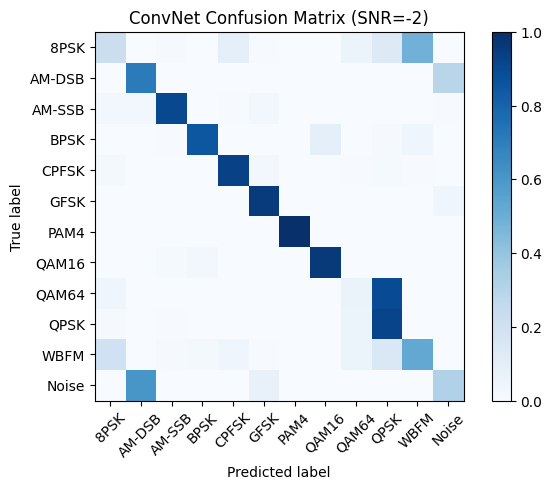

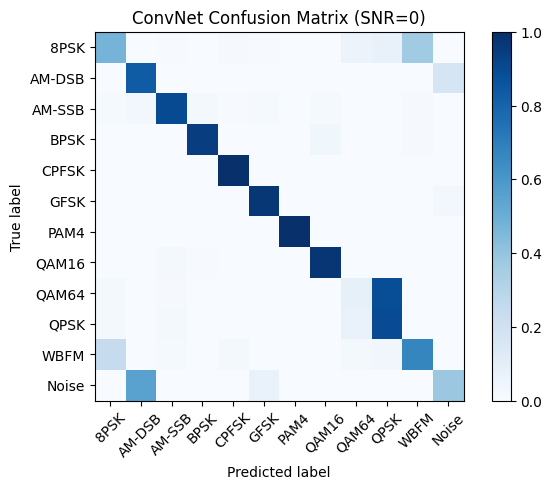

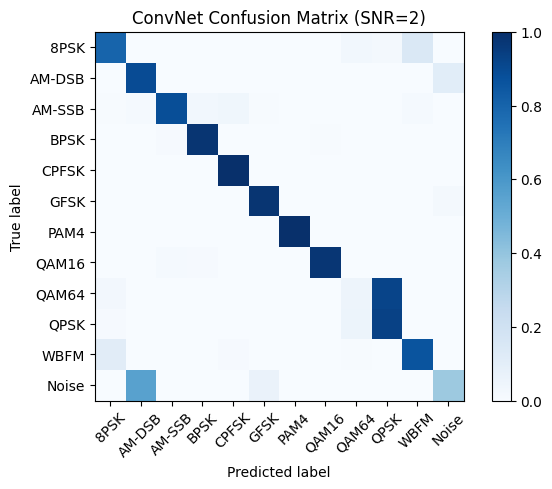

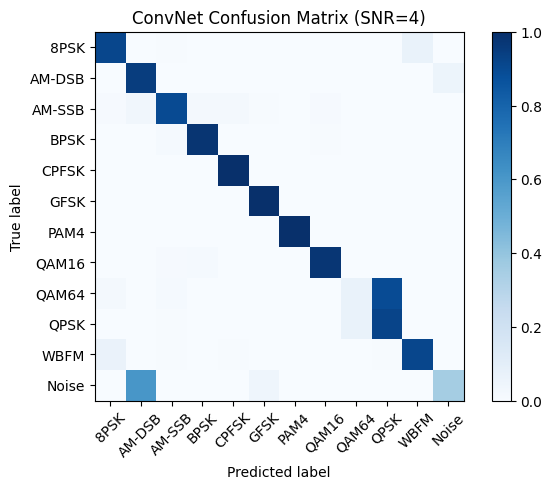

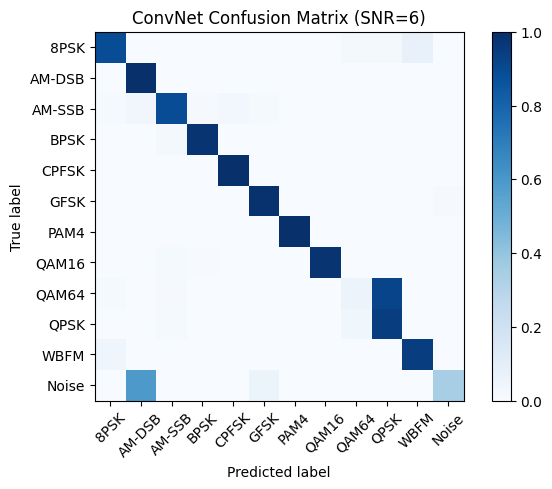

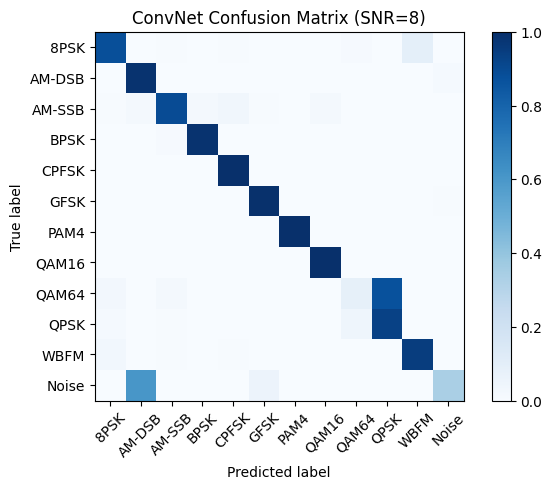

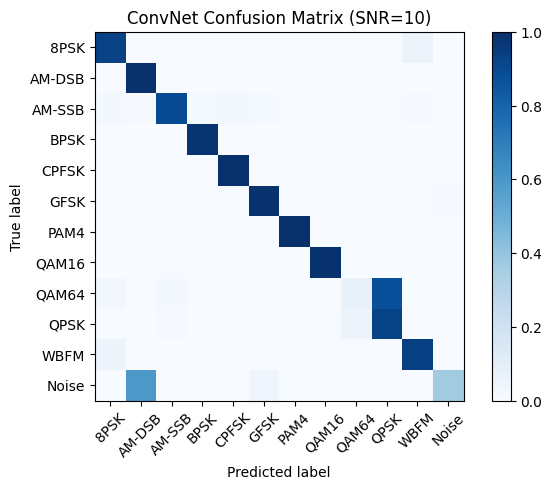

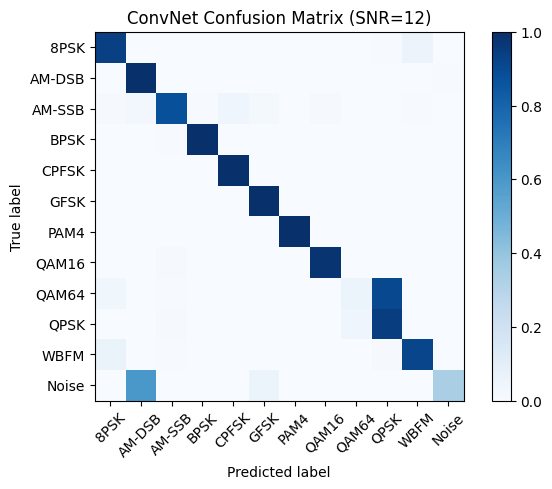

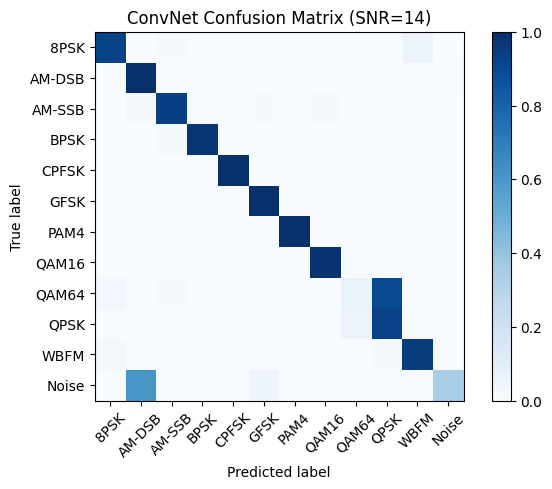

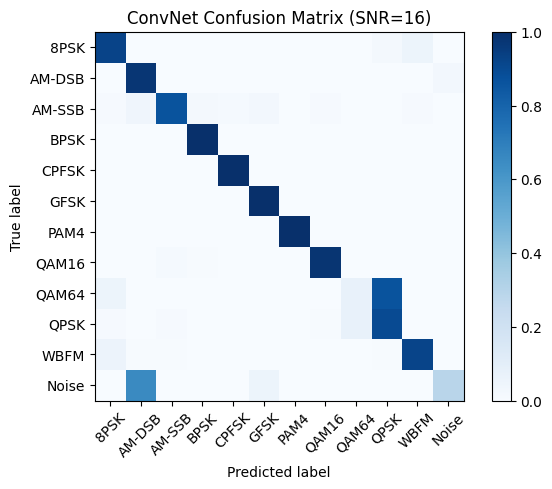

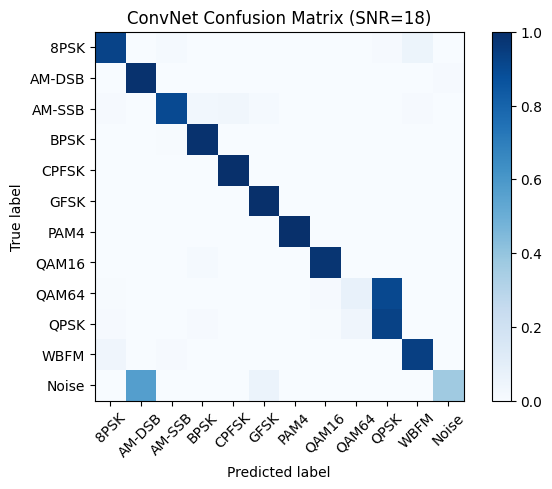

In [ ]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: int(lbl[x][1]), test_idx)
    test_S = []
    for i in test_SNRs:
      test_S.append(i)
    test_S = np.array(test_S)
    test_X_i = X_test[np.where(test_S == snr)]
    test_Y_i = Y_test[np.where(test_S == snr)]
    # estimate classes
    test_Y_i_hat = model.predict(test_X_i,verbose=0)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy for SNR {}: {}".format(snr, cor / (cor+ncor)))
    acc[snr] = 1.0*cor/(cor+ncor)

## ***Curva de precisión***

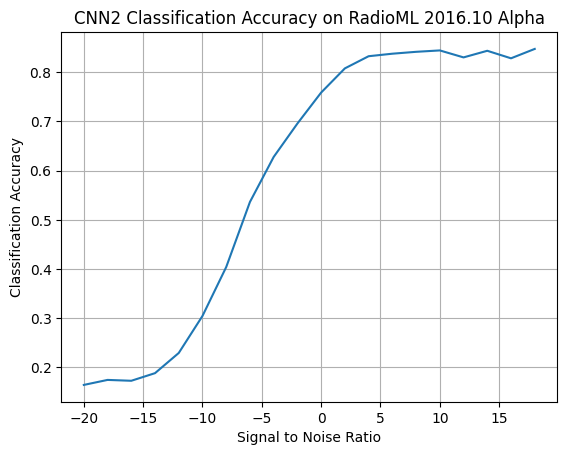

In [ ]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")
plt.grid()
plt.show()


## **Análisis**

En esta gráfica se observa que la curva de precisión de clasificación tiende a crecer en el intervalo de -15 a -10 dB hasta que llega a un punto de equilibrio en aproximadamente donde la señal sigue un valor constante en relaciones señales a ruido mayores.


En los cuatro casos no hubo mucha variación respecto a esta gráfica, se observaban cambios pequeños en su pendiente y en el punto de crecimiento de la curva.



# **Conclusiones**

- Implementar los modos de padding depende de la necesidad y la aplicación con la que se vayan a implementar debido a que cada uno tiene una forma distinta de ocupar la memoria para procesar los datos, entonces si estoy implementando el modelo en un entorno con poca capacidad de memoria es una mejor opción usar el modo 'valid'.


- Respecto a la gráfica de precisión de clasificación, se espera que un modelo que se comporte adecuadamente para este tipo de base de datos, debería mostrar una gráfica de precisión que tienda a crecer rápidamente, esto indicando que el valor de precisión de clasificación empiece a crecer en bajas relaciones señales a ruido, donde se sabe, que la señal está mermada por el ruido que la invade.


- La convergencia de la línea de validación hacia la de entrenamiento sugiere que el modelo también generaliza bien a datos no vistos, lo cual es un buen indicativo de la capacidad de generalización del modelo.


- La disminución de la pérdida a lo largo de las épocas en el conjunto de entrenamiento es positiva y esperada. Indica que el modelo está aprendiendo de manera efectiva los patrones presentes en los datos de entrenamiento.


- El uso de dropout es una estrategia efectiva para minimizar el sobreajuste durante la fase de entrenamiento del modelo, esta técnica consiste en apagar aleatoriamente un conjunto de unidades neuronales durante el entrenamiento, lo que impide que el modelo dependa en exceso de ciertos caminos de activación, esto, a su vez, promueve una mayor generalización y robustez del modelo frente a datos nuevos.


- La matriz de confusión ofrece una visión más detallada sobre cómo el modelo clasifica diferentes modulaciones. Al examinar los valores fuera de la diagonal principal de la matriz, se pueden entablar discusiones sobre la posible optimización de parámetros del modelo para mejorar sus predicciones.

